# ¿Autoencoders?



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

In [ ]:
latent_dim = 128 #Dimensión del vector latente

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(256, activation='relu'),
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
autoencoder(x_test).shape

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
print(encoded_imgs.shape)
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
decoded_imgs.shape

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Limpiando ruido

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis] # M, H, W, C
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

In [ ]:
#Agregando ruido
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.encoder.summary()
#autoencoder.decoder.summary()

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))


In [ ]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
decoded_imgs = autoencoder(x_test)

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()


# U-Net

Como ya se vio en la teoría, la red U-Net fue diseñada para realizar tareas de segmentación. Su peculiar arquitectura le hizo ganar su tan conocido nombre. 

Para entender cómo funciona, entrenaremos esta red desde cero.

In [ ]:
from skimage.io import imread
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np

from skimage.exposure import histogram
from skimage.morphology import binary_opening, binary_erosion, disk
from skimage.transform import rescale, resize

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Concatenate, BatchNormalization
from tensorflow import keras
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Análisis de los datos

Datos obtenidos de https://www.kaggle.com/balraj98/cityscapes-pix2pix-dataset.

Contienen 3475 imágenes de ciudad con su respectivo mapa de segmentación. Cada imagen está formada de dos partes: la imagen rgb y las etiquetas.

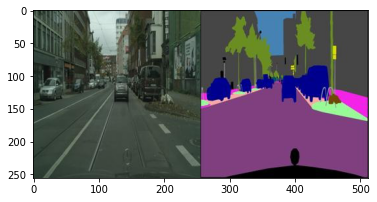

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/cityscapedataset/train'
TEST_PATH = '/content/drive/MyDrive/cityscapedataset/val'

train_imgs = glob(os.path.join(TRAIN_PATH, '*.jpg'))
test_imgs = glob(os.path.join(TEST_PATH, '*.jpg'))

plt.imshow(imread(train_imgs[0]))
plt.show()

### Preprocesamiento

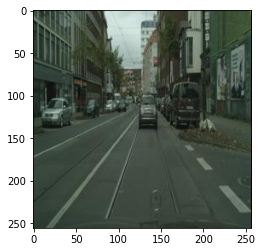

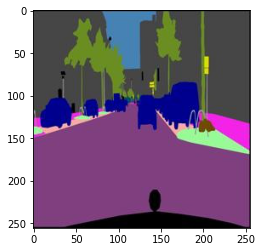

In [ ]:
#Separación de la imagen en rgb y etiquetas
def split(img):
    x_mid = img.shape[1]//2+1
    return img[:, :x_mid], img[:, x_mid:]

img = imread(train_imgs[0])
img_rgb, labels = split(img)
plt.imshow(img_rgb)
plt.show()
plt.imshow(labels)
plt.show()

[128  63 127]


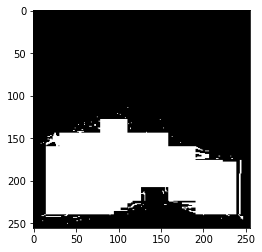

In [ ]:
print(labels[200, 100])
calle = np.logical_and(labels[..., 0]==128,
                        labels[..., 1]==63,
                        labels[..., 2]==127)
plt.imshow(calle, cmap='gray')
plt.show()

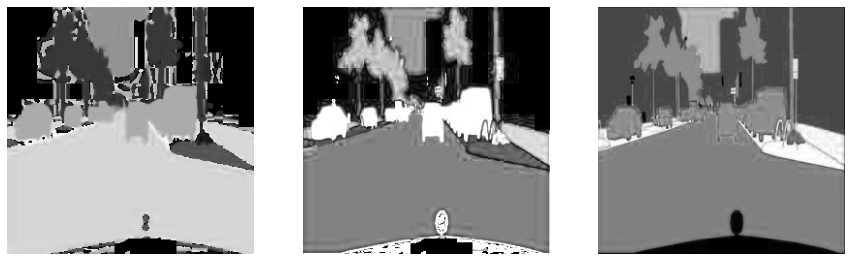

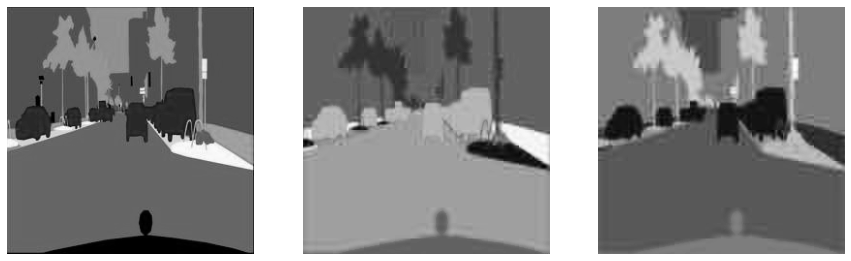

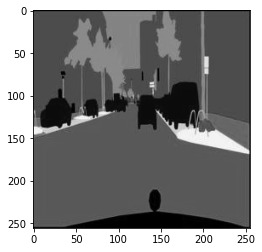

In [ ]:
## Extracción del la calle de las etiquetas
from skimage.color import rgb2hsv, rgb2lab, rgb2gray

hsv_img = rgb2hsv(labels)
lab_img = rgb2lab(labels)
fig, ax = plt.subplots(1,3, figsize=(15,10))
for k in range(3):
    ax[k].imshow(hsv_img[..., k], cmap='gray')
    ax[k].axis('off')
plt.show()

fig, ax = plt.subplots(1,3, figsize=(15,10))
for k in range(3):
    ax[k].imshow(lab_img[..., k], cmap='gray')
    ax[k].axis('off')
plt.show()

plt.imshow(rgb2gray(labels), cmap='gray')
plt.show()

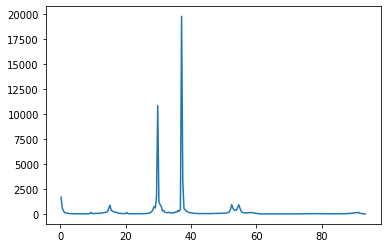

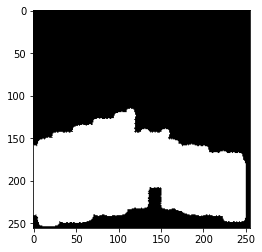

In [ ]:
labels_gray = lab_img[..., 0]
h, b = histogram(labels_gray)
plt.plot(b,h)
plt.show()

calle = np.logical_and(labels_gray>36,labels_gray<39)
calle = binary_opening(calle, disk(5))
plt.imshow(calle, cmap='gray')
plt.show()

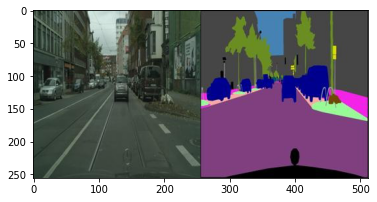

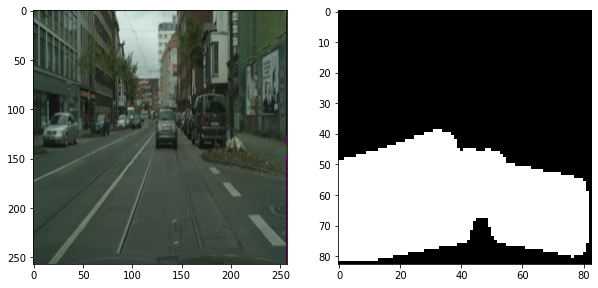

In [ ]:
def limpiar(img):
    rgb, labels = split(img)
    rgb = resize(rgb, (257,257))
    labels = resize(labels,(83,83)) #Tamaño explicado más adelante
    lab_labels = rgb2lab(labels)[..., 0]
    calle = np.logical_and(lab_labels>36,lab_labels<39)
    calle = binary_opening(calle, disk(5))
    return rgb, calle

img = imread(train_imgs[0])
plt.imshow(img)
plt.show()
rgb, mask = limpiar(img)
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(rgb)
ax[1].imshow(mask, cmap='gray')
plt.show()

In [ ]:
#Para la generación de lotes durante el entrenamiento
#Esto optimiza el uso de la memoria
def generar_lote(N, lista_archivos):
    selec = np.random.choice(lista_archivos, N, replace = False)
    imgs = []
    masks = []
    for fname in selec:
        rgb, mask = limpiar(imread(fname))
        imgs.append(rgb)
        masks.append(mask)
    X = tf.cast(tf.constant(imgs), tf.float32)
    y = tf.expand_dims(tf.cast(tf.constant(masks),tf.float32), axis=-1)
    return X, y

X, y = generar_lote(8, train_imgs)
X.shape, y.shape

(TensorShape([8, 257, 257, 3]), TensorShape([8, 83, 83, 1]))

## Diseño de la arquitectura

In [ ]:
#https://keras.io/examples/vision/oxford_pets_image_segmentation/

def down(last, filters):
    x = Conv2D(filters, kernel_size=3, activation='relu')(last)
    x = Conv2D(filters, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    
    pooled = MaxPool2D()(x)
    
    return pooled, x

def mid(last):
    x = Conv2D(1024, kernel_size=3, activation='relu')(last)
    x = Conv2D(1024, kernel_size=3, activation='relu')(x)
    x = Conv2DTranspose(512, kernel_size=3,strides=2)(x)
    return x

def up(last, skipped, filters_in, filters_out):
    skipped = crop(skipped, last.shape)
    x = Concatenate(axis=-1)([last, skipped])
    x = Conv2D(filters_in, kernel_size=3, activation='relu')(x)
    x = Conv2D(filters_in, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters_out, kernel_size=3, strides=2)(x)
    return x

def end(last, skipped, n_channels):
    skipped = crop(skipped, last.shape)
    x = Concatenate(axis=-1)([last, skipped])
    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(n_channels, kernel_size=1, activation='tanh')(x)
    
    return x
    

def crop(tensor, shape):
    rows, cols = shape[1:3]
    cols_floor, cols_ceil = int(cols/2), int(np.ceil(cols/2))
    rows_floor, rows_ceil = int(rows/2), int(np.ceil(rows/2))
    cx, cy = list(tensor.shape[1:3])
    return tensor[:,
                 cy//2-rows_floor:cy//2+rows_ceil,
                 cx//2-cols_floor:cx//2+cols_ceil,
                 :]

tensor = tf.ones((1,10,10,3))
crop(tensor, (1,3,7,3)).shape

TensorShape([1, 3, 7, 3])

In [ ]:
def armar_modelo(data_shape, n_clases):
    entrada = keras.Input(shape=data_shape[1:])
    x = entrada
    print(x.shape)
    
    skips = []
    for f in [64, 128, 256, 512]:
        x, s = down(x, f)
        skips.append(s)
    
    x = mid(x)
    skips = skips[::-1]
    
    for fi, fo, s in zip([512, 256, 128],[256, 128, 64], skips[:-1]):
        x = up(x, s, fi, fo)
    
    x = end(x, skips[-1], n_clases)
    
    modelo = keras.Model(entrada, x)
    return modelo

keras.backend.clear_session()
modelo = armar_modelo((1,257,257,3), 1)

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.BinaryCrossentropy()
metric = keras.metrics.SparseCategoricalAccuracy()
modelo.summary()

(None, 257, 257, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 257, 257, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 253, 253, 64  36928       ['conv2d[0][0]']                 
                                )                                         

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        res = modelo(x, training=True)
        loss = loss_fn(y, res)
    grads = tape.gradient(loss, modelo.trainable_weights)
    optimizer.apply_gradients(zip(grads, modelo.trainable_weights))
    metric.update_state(y, res)
    return loss

@tf.function
def predict(x):
    return modelo(x)

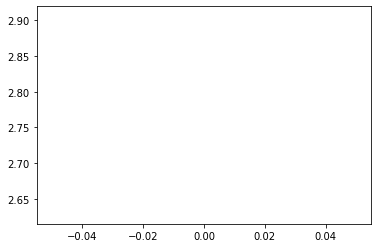

Epoca 0. Loss: 2.7672154903411865  -- 5.2seg
Epoca 1. Loss: 2.4399640560150146  -- 2.3seg
Epoca 2. Loss: 2.3807709217071533  -- 2.5seg
Epoca 3. Loss: 2.4337475299835205  -- 2.8seg
Epoca 4. Loss: 2.5275261402130127  -- 2.7seg
Epoca 5. Loss: 2.393284320831299  -- 2.4seg
Epoca 6. Loss: 2.2461912631988525  -- 2.3seg
Epoca 7. Loss: 1.995736002922058  -- 2.4seg
Epoca 8. Loss: 1.8474758863449097  -- 2.6seg
Epoca 9. Loss: 1.9213961362838745  -- 2.6seg


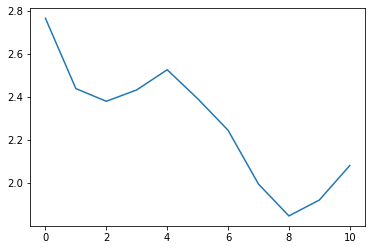

Epoca 10. Loss: 2.082024335861206  -- 2.8seg
Epoca 11. Loss: 1.8137871026992798  -- 2.2seg
Epoca 12. Loss: 1.9387834072113037  -- 2.7seg
Epoca 13. Loss: 1.524477481842041  -- 2.6seg
Epoca 14. Loss: 1.8770968914031982  -- 2.3seg
Epoca 15. Loss: 1.8308155536651611  -- 2.4seg
Epoca 16. Loss: 1.639028549194336  -- 4.4seg
Epoca 17. Loss: 2.4765820503234863  -- 2.4seg
Epoca 18. Loss: 2.429624319076538  -- 2.5seg
Epoca 19. Loss: 2.074860095977783  -- 2.5seg


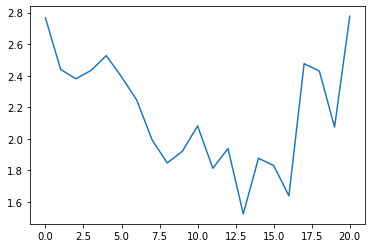

Epoca 20. Loss: 2.7770514488220215  -- 3.0seg
2.7360195886521113 segundos promedio por época


In [ ]:
import time
n_batch= 8
epocas = 20
loss_log = []
times = []
for epoca in range(epocas+1):
    t0 = time.time()
    X, y = generar_lote(n_batch, train_imgs)
    loss = train_step(X, y)
    
    loss_log.append(loss)

    if epoca%10==0:
        plt.plot(loss_log)
        plt.show()
    t1 = time.time()
    print(f'\rEpoca {epoca}. Loss: {loss.numpy()}  -- {t1-t0:.2}seg')
    times.append(t1-t0)

print(sum(times)/len(times),'segundos promedio por época')

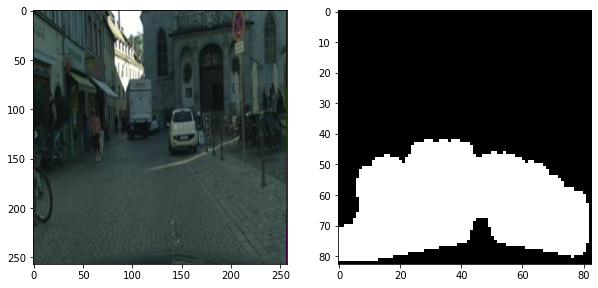

In [ ]:
img, mask = generar_lote(3, test_imgs)
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img[0])
ax[1].imshow(mask[0, ..., 0], cmap='gray')
plt.show()

0.4586832 (83, 83)


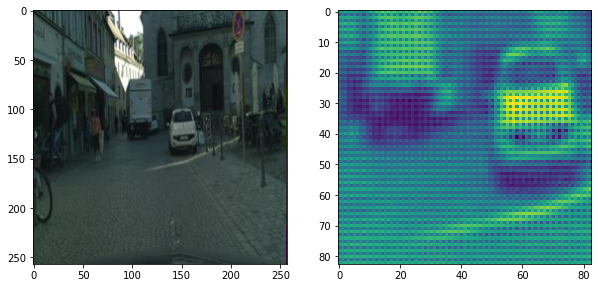

In [ ]:
prediccion = predict(img)
pred = prediccion[0, ..., 0]
print(np.max(pred), pred.shape)
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img[0])
ax[1].imshow(pred)
plt.show()

#Probando una red preentrenada

Red entrenada con el conjunto de datos https://conferences.mpi-inf.mpg.de/dagm/2007/prizes.html

El modelo se encuentra en https://tfhub.dev/nvidia/unet/industrial/class_1/1

In [ ]:
#Obteniendo solo una parte de los datos
#!wget https://conferences.mpi-inf.mpg.de/dagm/2007/Class1.zip ; unzip -q Class1.zip
!wget https://conferences.mpi-inf.mpg.de/dagm/2007/Class1_def.zip ; unzip -q Class1_def.zip

--2021-12-01 03:22:14--  https://conferences.mpi-inf.mpg.de/dagm/2007/Class1_def.zip
Resolving conferences.mpi-inf.mpg.de (conferences.mpi-inf.mpg.de)... 139.19.206.169
Connecting to conferences.mpi-inf.mpg.de (conferences.mpi-inf.mpg.de)|139.19.206.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34556484 (33M) [application/zip]
Saving to: ‘Class1_def.zip’

Class1_def.zip      100%[===================>]  32.96M  16.2MB/s    in 2.0s    

2021-12-01 03:22:17 (16.2 MB/s) - ‘Class1_def.zip’ saved [34556484/34556484]



In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg

tf.compat.v1.disable_eager_execution()
module = hub.Module("https://tfhub.dev/nvidia/unet/industrial/class_1/1",
                    trainable=False)

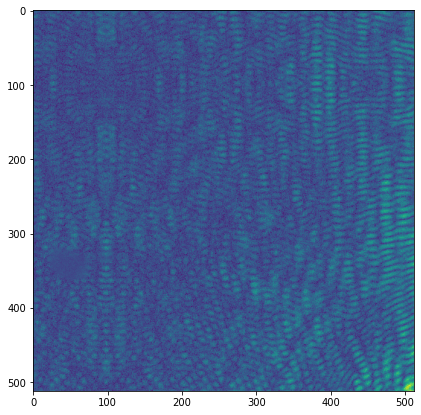

In [ ]:
img = mpimg.imread('Class1_def/10.png')
img =  np.expand_dims(img, axis=2)
img =  np.expand_dims(img, axis=0)
img = (img-0.5)/0.5

plt.figure(figsize=(7,7))
plt.imshow(img[0,...,0])
plt.show()

In [ ]:
output = module(img)
with tf.compat.v1.Session() as sess:
    sess.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
    pred = sess.run(output)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


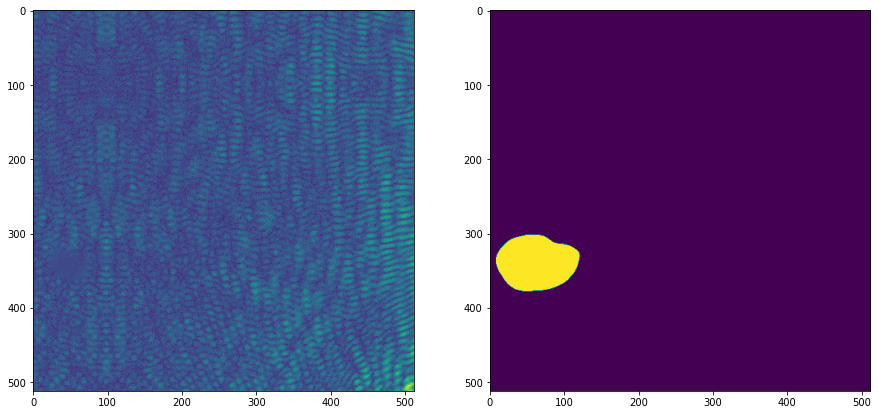

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(img[0,...,0])
ax[1].imshow(pred[0,...,0])
plt.show()